# Some attempt at Particle Tracking

In [72]:
# Importing things

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.fft import fft, fftfreq

In [73]:
# where is the data?
loc = 'C:/Users/abiga/OneDrive - Durham University/1. Fourth Year/1. Project/Memory Stick Backup/2024-03-11/'
filename = 'Results.csv'

# read in as dataframe
df = pd.read_csv(loc + filename)

# select x and y positions of bead for all 83 frames
# get rid of anomalous last point
x = np.array(df['x'])[:-1]
y = np.array(df['y'])[:-1]

Text(0, 0.5, 'y / pixels')

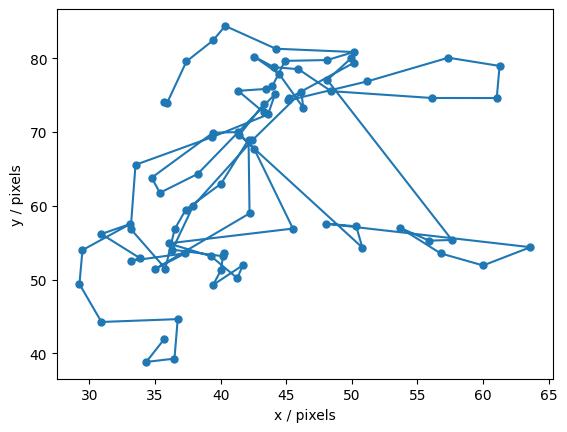

In [74]:
# Plot x and y trajectory

plt.errorbar(x,y, ms = 5, fmt = 'o', linestyle = '-')
plt.xlabel('x / pixels')
plt.ylabel('y / pixels')

Text(0, 0.5, 'Position / pixels')

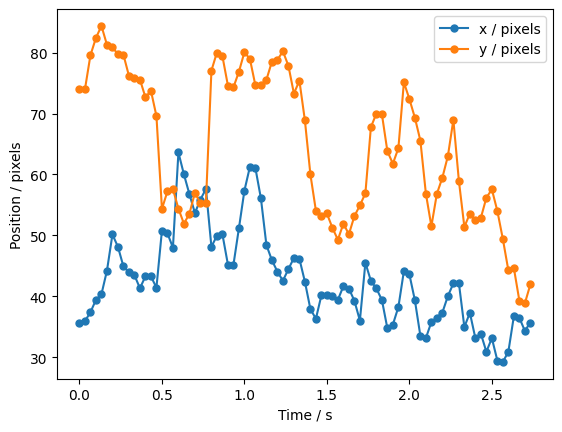

In [75]:
# Frames per second on camera
fps = 30
fps_err = 1

# Set time axis in seconds
time = np.arange(x.size) / 30

# plot x and y over time
plt.errorbar(time,x, ms = 5, fmt = 'o', linestyle = '-', label = 'x / pixels')
plt.errorbar(time,y, ms = 5, fmt = 'o', linestyle = '-', label = 'y / pixels')
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Position / pixels')

Text(0, 0.5, 'Fourier Transform Squared / Arb Units')

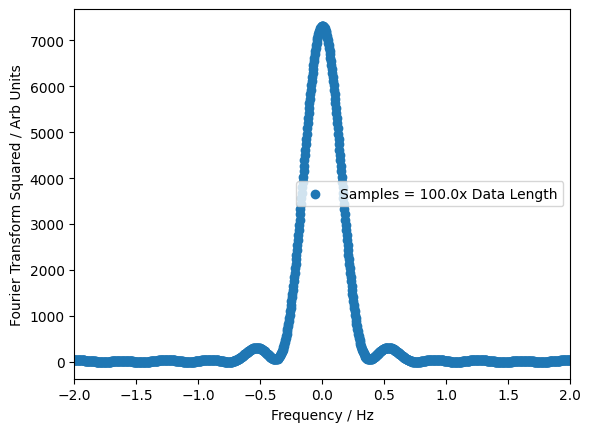

In [84]:
def fourier_test(data,sample_number):

    # Compute transform and normalise by length / 2
    fast_four = fft(data, n = sample_number) / (len(data) / 2)

    # Compute amplitude squared
    ps = np.abs(fast_four)**2

    # Calculate frequency components (is the sample spacing right?)
    freq = fftfreq(sample_number, d=1.0/fps)

    plt.scatter(freq, ps, label = 'Samples = {}x Data Length'.format(sample_number / x.size))
    plt.legend()

    return []

# Some numbers to stick in fourier transform
numbers = np.array([1,10,100,1000,10000])*x.size

# Plot using above function

plot = fourier_test(x,100*x.size)
plt.xlim(-2,2)
plt.xlabel('Frequency / Hz')
plt.ylabel('Fourier Transform Squared / Arb Units')

In [77]:
print(freq)

[ 0.     0.003  0.006 ... -0.009 -0.006 -0.003]
